In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import time
from pickle import load, dump
import copy

# Data Generation

In [3]:
def checkerboard4(num_train, num_test, num_grid_col=4, num_grid_row=4, position=0):
    if num_train%2:
        raise ValueError(f"This method wants to create a balanced dataset but received"
                f"odd num_train={num_train}.")
    if num_test%2:
        raise ValueError(f"This method wants to create a balanced dataset but received"
                f"odd num_test={num_test}.")
    num_total = num_train + num_test
    max_samples = num_grid_row * num_grid_col * 40
    if num_total>max_samples:
        raise ValueError(f"Due to intricate legacy reasons, the number of samples"
                f"may not exceed {max_samples}. Received {num_total}.")
    # creating negative (-1) and positive (+1) samples
    negatives = []
    positives = []
    for i in range(num_grid_col):
        for j in range(num_grid_row):
            data = (np.random.random((40,2))-0.5)
            data[:,0] = (data[:,0]+2*i+1)/(2*num_grid_col)
            data[:,1] = (data[:,1]+2*j+1)/(2*num_grid_row)
            if i%2==j%2:
                negatives.append(data)
            else:
                positives.append(data)
    negative = np.vstack(negatives)
    positive = np.vstack(positives)

    # split the data
    np.random.shuffle(negative)
    np.random.shuffle(positive)

    X_train = np.vstack([negative[:num_train//2], positive[:num_train//2]])
    y_train = np.hstack([-np.ones((num_train//2)), np.ones((num_train//2))])
    X_test = np.vstack([negative[num_train//2:num_total//2], positive[num_train//2:num_total//2]])
    y_test = np.hstack([-np.ones((num_test//2)), np.ones((num_test//2))])

    r0 = [X_train, y_train, X_test, y_test]

    X_train_l = X_train[np.where(X_train[:,0] <= 0.5)]
    y_train_l = y_train[np.where(X_train[:,0] <= 0.5)]
    X_test_l = X_test[np.where(X_test[:,0] <= 0.5)]
    y_test_l = y_test[np.where(X_test[:,0] <= 0.5)]

    r1 = [X_train_l[np.where(X_train_l[:,1] <= 0.5)],y_train_l[np.where(X_train_l[:,1] <= 0.5)],X_test_l[np.where(X_test_l[:,1] <= 0.5)],y_test_l[np.where(X_test_l[:,1] <= 0.5)]]
    r3 = [X_train_l[np.where(X_train_l[:,1] >= 0.5)],y_train_l[np.where(X_train_l[:,1] >= 0.5)],X_test_l[np.where(X_test_l[:,1] >= 0.5)],y_test_l[np.where(X_test_l[:,1] >= 0.5)]]

    X_train_r = X_train[np.where(X_train[:,0] >= 0.5)]
    y_train_r = y_train[np.where(X_train[:,0] >= 0.5)]
    X_test_r = X_test[np.where(X_test[:,0] >= 0.5)]
    y_test_r = y_test[np.where(X_test[:,0] >= 0.5)]

    r2 = [X_train_r[np.where(X_train_r[:,1] <= 0.5)],y_train_r[np.where(X_train_r[:,1] <= 0.5)],X_test_r[np.where(X_test_r[:,1] <= 0.5)],y_test_r[np.where(X_test_r[:,1] <= 0.5)]]

    r4 = [X_train_r[np.where(X_train_r[:,1] >= 0.5)],y_train_r[np.where(X_train_r[:,1] >= 0.5)],X_test_r[np.where(X_test_r[:,1] >= 0.5)],y_test_r[np.where(X_test_r[:,1] >= 0.5)]]

    return r0, r1, r2, r3, r4

In [4]:
np.random.seed(43) # Seed, 43 was used for the paper results

In [5]:
num_train = 60 # Number of training datapoints
num_test = 60 # Number of test datapoints

num_random_params = 3 # Number of random parameter positions.
num_epochs = 100 # Number of epochs for target alignment training

xlims = [0, 1]
ylims = [0, 1]

In [6]:
r0, r1, r2, r3, r4 = checkerboard4(num_train, num_test, num_grid_row=4, num_grid_col=4,position=4)

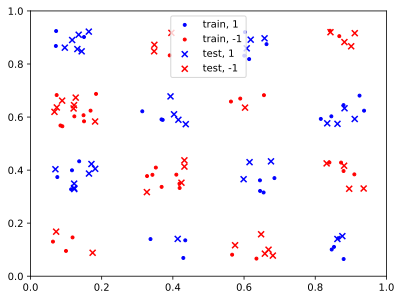

In [7]:
X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

# Gaussian Kernel Experiments

## Centralized training with Gaussian kernel

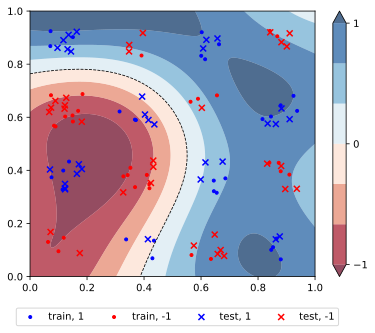

In [8]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [9]:
def prediction_accuracy(y_predicted, y_target):
    return 1 - np.count_nonzero(y_predicted - y_target) / len(y_target)

In [10]:
trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on train", trained_train_accuracy)
print("with kernel training accuracy on test", trained_test_accuracy)

with kernel training accuracy on train 0.65
with kernel training accuracy on test 0.5166666666666666


## Local training with Gaussian kernel at node 1

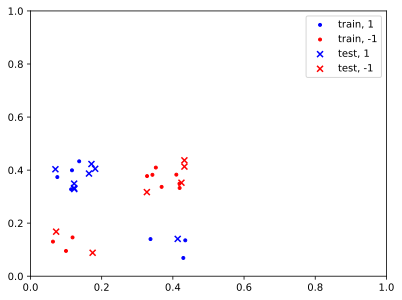

In [11]:
X_train, y_train, X_test, y_test = tuple(r1)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

with kernel training accuracy on self_train 1.0
with kernel training accuracy on self_test 1.0
with kernel training accuracy on whole_test 0.5


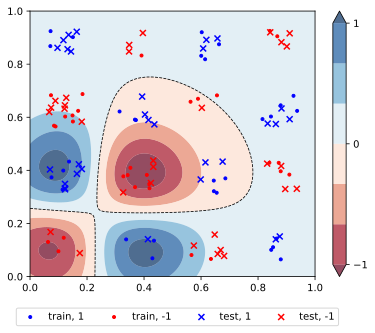

In [12]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Gaussian kernel at node 2

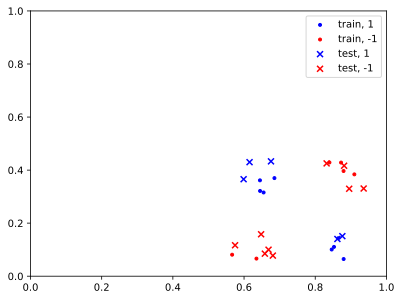

In [16]:
X_train, y_train, X_test, y_test = tuple(r2)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

with kernel training accuracy on self_train 0.8571428571428572
with kernel training accuracy on self_test 0.6428571428571428
with kernel training accuracy on whole_test 0.5666666666666667


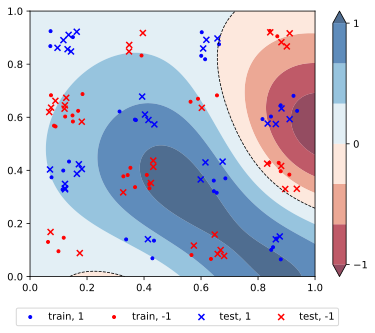

In [17]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Gaussian kernel at node 3

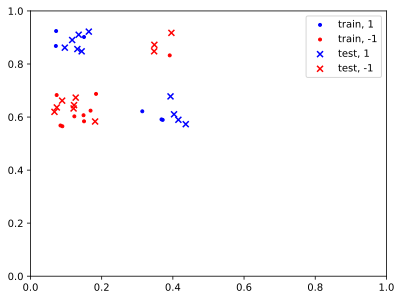

In [18]:
X_train, y_train, X_test, y_test = tuple(r3)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

with kernel training accuracy on self_train 0.8666666666666667
with kernel training accuracy on self_test 0.85
with kernel training accuracy on whole_test 0.5166666666666666


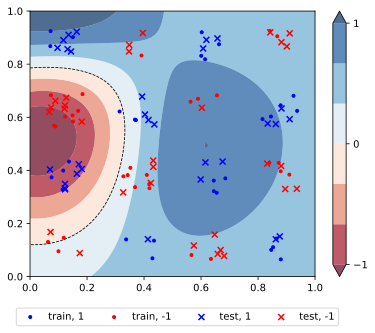

In [19]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Gaussian kernel at node 4

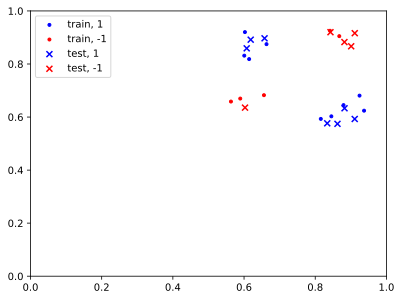

In [20]:
X_train, y_train, X_test, y_test = tuple(r4)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

with kernel training accuracy on self_train 1.0
with kernel training accuracy on self_test 1.0
with kernel training accuracy on whole_test 0.5166666666666666


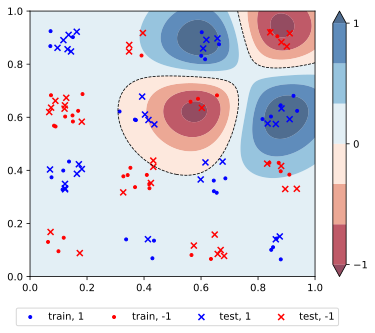

In [21]:
RBFsvm = SVC(kernel='rbf').fit(X_train, y_train)
precision = 200 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
prediction_r = RBFsvm.decision_function(X_grid)
z = np.reshape(prediction_r, xx.shape)

trained_train_predict = RBFsvm.predict(X_train)
trained_test_predict = RBFsvm.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on self_train", trained_train_accuracy)
print("with kernel training accuracy on self_test", trained_test_accuracy)

X_train, y_train, X_test, y_test = tuple(r0)

trained_test_predict = RBFsvm.predict(X_test)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on whole_test", trained_test_accuracy)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

# Quantum kernel Training Preparation

In [10]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding Ansatz.
    Args:
        x (ndarray): Data to be embedded.
        params (ndarray): Trainable circuit parameters.
        wires (qml.Wires): Qubits to act on.
        i0 (int): Wire on which the first embedding rotation gate acts.
        inc (int): Increment between wires on which the embedding rotation gates act.
    Comments:
        Note that this circuit iterates cyclically over the feature vector to be embedded.
    """
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding Ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

def prediction_accuracy(y_predicted, y_target):
    return 1 - np.count_nonzero(y_predicted - y_target) / len(y_target)

def get_random_params(num_wires, num_layers):
    return np.random.uniform(0, 2*np.pi, (num_layers, 2, num_wires))

def target_alignment(X,Y,kernel,assume_normalized_kernel=False,rescale_class_labels=True):
    """Kernel-target alignment between kernel and labels."""
    K = qml.kernels.square_kernel_matrix(X,kernel,assume_normalized_kernel=assume_normalized_kernel)

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [11]:
num_wires = 5 # Number of qubits / Width of the circuit
num_layers = 8 # Number of building blocks / "Depth" of the circuit

## Local training with Quantum kernel at node 1

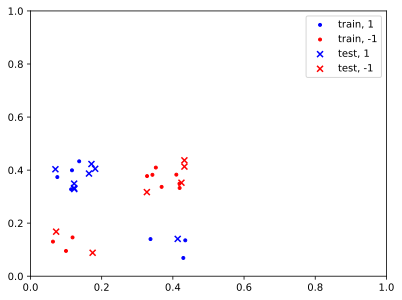

In [12]:
X_train, y_train, X_test, y_test = tuple(r1)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

11.962570905685425
0.4285714285714286
302.46172881126404


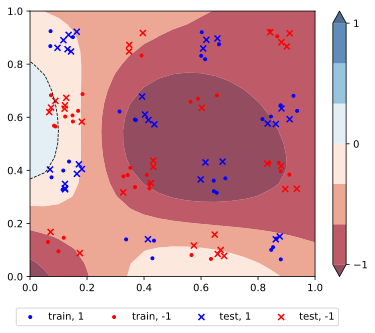

In [13]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r1_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

Step 0 - Alignment on train = 0.041


  0%|          | 0/1000 [00:00<?, ?it/s]

Step 50 - Alignment on train = 0.250
Step 100 - Alignment on train = 0.268
Step 150 - Alignment on train = 0.300
Step 200 - Alignment on train = 0.366
Step 250 - Alignment on train = 0.404
Step 300 - Alignment on train = 0.434
Step 350 - Alignment on train = 0.456
Step 400 - Alignment on train = 0.485
Step 450 - Alignment on train = 0.485
Step 500 - Alignment on train = 0.495
Step 550 - Alignment on train = 0.499
Step 600 - Alignment on train = 0.508
Step 650 - Alignment on train = 0.511
Step 700 - Alignment on train = 0.504
Step 750 - Alignment on train = 0.502
Step 800 - Alignment on train = 0.487
Step 850 - Alignment on train = 0.520
Step 900 - Alignment on train = 0.520
Step 950 - Alignment on train = 0.515
Step 1000 - Alignment on train = 0.500


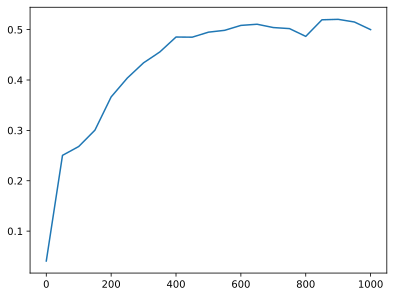

In [14]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r1)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r1_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

with kernel training accuracy on test 1.0
305.59817266464233


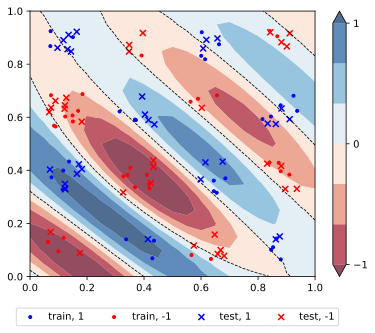

In [15]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)


precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Quantum kernel at node 2

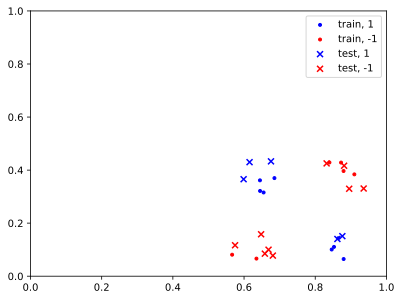

In [53]:
X_train, y_train, X_test, y_test = tuple(r2)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

6.9443042278289795
0.3571428571428571
219.12518095970154


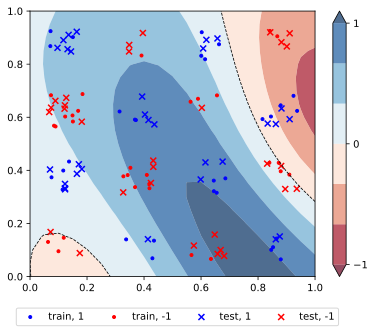

In [54]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r2_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

In [55]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r2)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r2_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

Step 0 - Alignment on train = 0.032


  0%|          | 0/1000 [00:00<?, ?it/s]

1.390702247619629
1.4237823486328125
1.498906135559082
1.52119779586792
1.5422916412353516
1.1466078758239746
1.563894510269165
1.554809331893921
1.5547077655792236
1.5538203716278076
1.5583834648132324
1.5255513191223145
1.1427509784698486
1.534437656402588
1.5602519512176514
1.5541448593139648
1.530980110168457
1.5492701530456543
1.5819485187530518
1.1414427757263184
1.5480098724365234
1.5389881134033203
1.5516915321350098
1.5447087287902832
1.55070161819458
1.5286061763763428
1.141280174255371
1.5409045219421387
1.5369303226470947
1.5784697532653809
1.569176197052002
1.535301685333252
1.546584129333496
1.149630069732666
1.5985980033874512
1.722334623336792
1.572495937347412
1.6275436878204346
1.7539608478546143
1.6371376514434814
1.151048183441162
1.618537425994873
1.5743327140808105
1.5913214683532715
1.6012110710144043
1.5269052982330322
1.5655062198638916
1.135319709777832
1.5716261863708496
1.5547709465026855
Step 50 - Alignment on train = 0.387
1.3458073139190674
1.454604387283

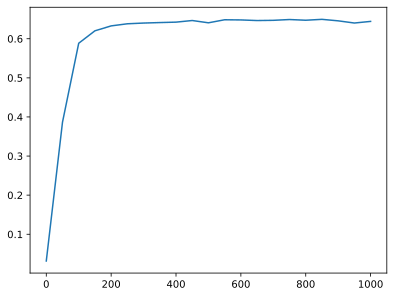

In [68]:
x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

with kernel training accuracy on test 1.0
218.45955109596252


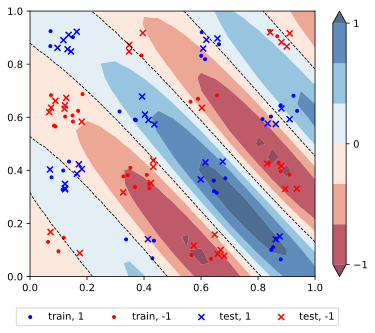

In [56]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Quantum kernel at node 3

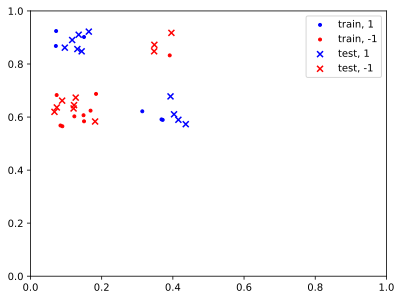

In [69]:
X_train, y_train, X_test, y_test = tuple(r3)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

7.999491930007935
0.6
242.4929976463318


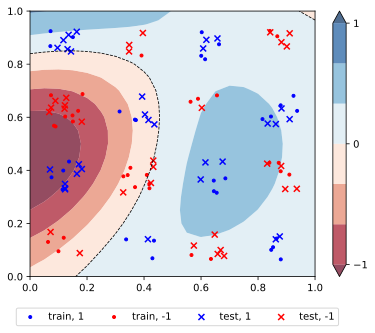

In [70]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r3_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

Step 0 - Alignment on train = 0.046


  0%|          | 0/1000 [00:00<?, ?it/s]

Step 50 - Alignment on train = 0.214
Step 100 - Alignment on train = 0.341
Step 150 - Alignment on train = 0.381
Step 200 - Alignment on train = 0.440
Step 250 - Alignment on train = 0.465
Step 300 - Alignment on train = 0.468
Step 350 - Alignment on train = 0.477
Step 400 - Alignment on train = 0.487
Step 450 - Alignment on train = 0.501
Step 500 - Alignment on train = 0.493
Step 550 - Alignment on train = 0.512
Step 600 - Alignment on train = 0.519
Step 650 - Alignment on train = 0.519
Step 700 - Alignment on train = 0.519
Step 750 - Alignment on train = 0.518
Step 800 - Alignment on train = 0.521
Step 850 - Alignment on train = 0.509
Step 900 - Alignment on train = 0.522
Step 950 - Alignment on train = 0.519
Step 1000 - Alignment on train = 0.519


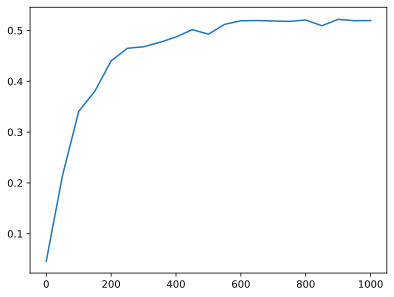

In [72]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r3)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r3_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

with kernel training accuracy on test 1.0
240.02161717414856


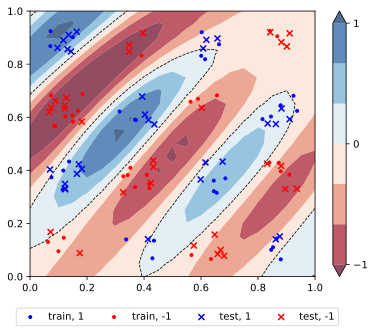

In [73]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Local training with Quantum kernel at node 4

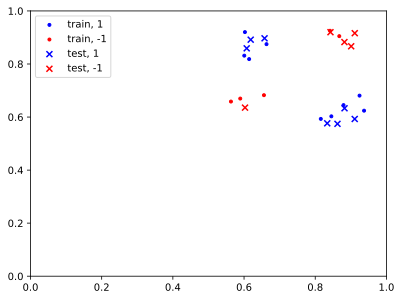

In [11]:
X_train, y_train, X_test, y_test = tuple(r4)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

7.156491041183472
0.5833333333333333
219.30096292495728


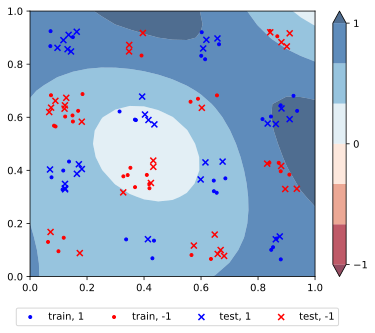

In [12]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r4_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

Step 0 - Alignment on train = 0.030


  0%|          | 0/1000 [00:00<?, ?it/s]

Step 50 - Alignment on train = 0.148
Step 100 - Alignment on train = 0.256
Step 150 - Alignment on train = 0.331
Step 200 - Alignment on train = 0.359
Step 250 - Alignment on train = 0.370
Step 300 - Alignment on train = 0.392
Step 350 - Alignment on train = 0.402
Step 550 - Alignment on train = 0.425
Step 600 - Alignment on train = 0.429
Step 650 - Alignment on train = 0.429
Step 700 - Alignment on train = 0.433
Step 750 - Alignment on train = 0.436
Step 800 - Alignment on train = 0.434
Step 850 - Alignment on train = 0.442
Step 900 - Alignment on train = 0.445
Step 950 - Alignment on train = 0.448
Step 1000 - Alignment on train = 0.443


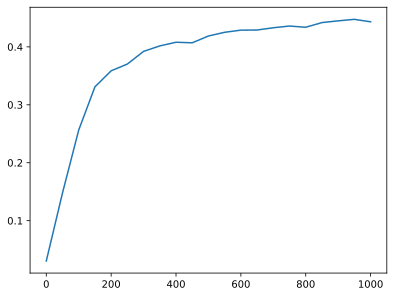

In [ ]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r4)

num_epochs = 1000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r4_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

with kernel training accuracy on test 1.0
216.4292438030243


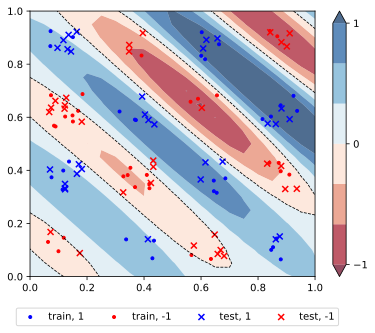

In [14]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

## Centralized training with Quantum kernel

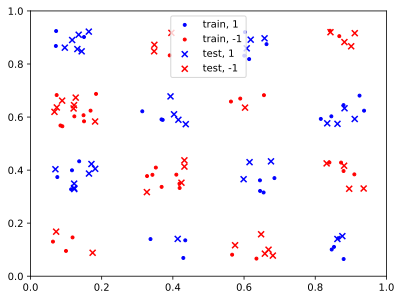

In [22]:
X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:,0], X_train_pos[:,1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:,0], X_train_neg[:,1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:,0], X_test_pos[:,1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:,0], X_test_neg[:,1], color="r", marker="x", label="test, -1")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend()

130.29983830451965
0.5166666666666666
956.9495062828064


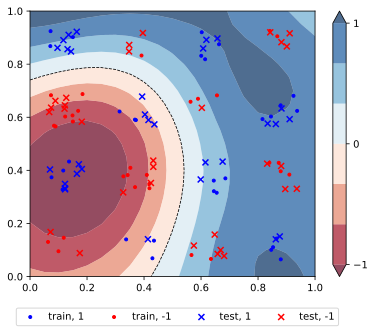

In [43]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

params = get_random_params(num_wires, num_layers)

with open('p_r0_ini.pickle', 'wb') as f:
    dump(params, f)

# print(params)
## fit the SVM on the training data
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
start = time.time()
svm_untrained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
end = time.time()
print (str(end-start))
## evaluate on the test set
rp_tr = svm_untrained_kernel.predict(X_train)
rp_te = svm_untrained_kernel.predict(X_test)
untrained_accuracy_train = prediction_accuracy(rp_tr, y_train)
untrained_accuracy_test = prediction_accuracy(rp_te, y_test)
# print("without kernel training accuracy", untrained_accuracy_test)
value = untrained_accuracy_test
print(value)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_untrained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)
cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train, y_train, X_test, y_test = tuple(r0)

X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))

Step 0 - Alignment on train = 0.023


  0%|          | 0/5000 [00:00<?, ?it/s]

Step 50 - Alignment on train = 0.040
Step 100 - Alignment on train = 0.042
Step 150 - Alignment on train = 0.051
Step 200 - Alignment on train = 0.055
Step 250 - Alignment on train = 0.066
Step 300 - Alignment on train = 0.069
Step 350 - Alignment on train = 0.069
Step 400 - Alignment on train = 0.064
Step 450 - Alignment on train = 0.075
Step 500 - Alignment on train = 0.084
Step 550 - Alignment on train = 0.085
Step 600 - Alignment on train = 0.105
Step 650 - Alignment on train = 0.109
Step 700 - Alignment on train = 0.118
Step 750 - Alignment on train = 0.156
Step 800 - Alignment on train = 0.227
Step 850 - Alignment on train = 0.301
Step 900 - Alignment on train = 0.323
Step 950 - Alignment on train = 0.350
Step 1000 - Alignment on train = 0.402
Step 1050 - Alignment on train = 0.423
Step 1100 - Alignment on train = 0.448
Step 1150 - Alignment on train = 0.430
Step 1200 - Alignment on train = 0.482
Step 1250 - Alignment on train = 0.494
Step 1300 - Alignment on train = 0.481
Step 1

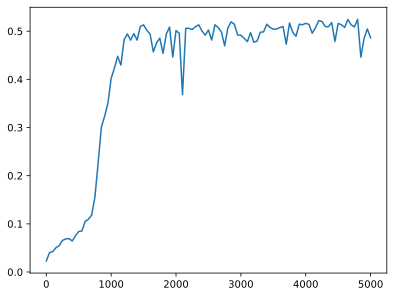

In [44]:
dev = qml.device("default.qubit", wires=num_wires)
wires = list(range(num_wires))
# @qml.qnode(dev)
@qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

X_train, y_train, X_test, y_test = tuple(r0)

num_epochs = 2000 # Number of epochs for target alignment training

training_alignment = []
mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
training_alignment.append(alignment)
print("Step 0 - Alignment on train = {:.3f}".format(alignment))
opt = qml.GradientDescentOptimizer(2)
# opt = qml.NesterovMomentumOptimizer(2)
# opt = qml.AdamOptimizer(2)
# opt = qml.QNGOptimizer(2)
for i in tqdm(range(num_epochs)):
    # We train on a small random subset of the training data set
    # start = time.time()
    subset = np.random.choice(list(range(len(X_train))), 4)
    mapped_neg_alignment = lambda par: -target_alignment(X_train[subset],y_train[subset],lambda X1, X2: kernel(X1, X2, par),assume_normalized_kernel=True,rescale_class_labels=True)
    params = opt.step(mapped_neg_alignment, params)
    # end = time.time()
    # print (str(end-start))
    if (i+1) % 50 == 0:
        mapped_kernel = lambda X1, X2: kernel(X1, X2, params)
        alignment = target_alignment(X_train,y_train,mapped_kernel,assume_normalized_kernel=True,rescale_class_labels=True)
        training_alignment.append(alignment)
        print("Step {} - Alignment on train = {:.3f}".format(i+1, alignment))
trained_params = params.copy()

with open('p_r0_tra.pickle', 'wb') as f:
    dump(trained_params, f)

x = np.linspace(0,num_epochs,int(num_epochs/50)+1)
plt.plot(x,training_alignment)

with kernel training accuracy on test 1.0
943.0216076374054


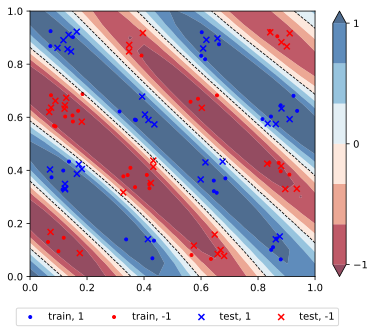

In [48]:
dev = qml.device("lightning.qubit", wires=num_wires)
wires = list(range(num_wires))
@qml.qnode(dev)
# @qml.qnode(dev, diff_method="backprop")
# @qml.qnode(dev, diff_method="backprop", interface="autograd")
def kernel(x1, x2, params):
    ansatz(x1, params, wires)
    qml.adjoint(ansatz)(x2, params, wires)
    return qml.expval(qml.Projector([0]*num_wires, wires=wires))

## fit the SVM on the train set
mapped_kernel = lambda X1, X2: kernel(X1, X2, trained_params)
mapped_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, mapped_kernel)
svm_trained_kernel = SVC(kernel=mapped_kernel_matrix).fit(X_train, y_train)
## evaluate the accuracy on the test set
trained_train_predict = svm_trained_kernel.predict(X_train)
trained_test_predict = svm_trained_kernel.predict(X_test)
trained_train_accuracy = prediction_accuracy(trained_train_predict, y_train)
trained_test_accuracy = prediction_accuracy(trained_test_predict, y_test)
print("with kernel training accuracy on test", trained_test_accuracy)

precision = 20 # higher is more precise and more compute time
xx, yy = np.meshgrid(np.linspace(0,precision,precision+1)/precision, np.linspace(0,precision,precision+1)/precision)
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
start = time.time()
prediction_r = svm_trained_kernel.decision_function(X_grid)
end = time.time()
print (str(end-start))
z = np.reshape(prediction_r, xx.shape)

X_train, y_train, X_test, y_test = tuple(r0)

cm = plt.cm.RdBu
cnt = plt.contourf(xx,yy,z, levels=np.arange(-1, 1+1/3, 1/3), cmap=cm, alpha=0.7, extend="both")
plt.contour(xx, yy, z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])
X_train_pos = X_train[np.where(y_train == 1)[0],:]
X_train_neg = X_train[np.where(y_train == -1)[0],:]
X_test_pos = X_test[np.where(y_test == 1)[0],:]
X_test_neg = X_test[np.where(y_test == -1)[0],:]
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], color="b", marker=".", label="train, 1")
plt.scatter(X_train_neg[:, 0], X_train_neg[:, 1], color="r", marker=".", label="train, -1")
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], color="b", marker="x", label="test, 1")
plt.scatter(X_test_neg[:, 0], X_test_neg[:, 1], color="r", marker="x", label="test, -1")
plt.legend(ncol=4,bbox_to_anchor=(1.1,-0.1))